## ARIMA-Based Trading Strategy

We use an ARIMA model to forecast the next-period log return:

$$
\hat{y}_{t} = \text{ARIMA}(p,d,q)\big(y_{t-1}, y_{t-2} \ldots \big)
$$

where:

- $ y_{t-1} $ is the log return at time \( t -1 \)
- $ \hat{y}_{t} $ is the ARIMA forecast for the current period

### Trading Rules

Trading signals are generated based on the sign of the forecast:

$$
\text{signal}_{t} =
\begin{cases}
+1, & \text{if } \hat{y}_{t} > 0 \quad \text{(go Long)} \\
-1, & \text{if } \hat{y}_{t} < 0 \quad \text{(go Short)}
\end{cases}
$$


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import numpy as np
import processing_data as pr
import feature_engineer as fe 
import data_generator as dg
import detect_and_handle_outlier as outlier
import matplotlib.pyplot as plt

In [ ]:
csv_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\stocks_data\AAPL.csv"
SP_500_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\S&P_500"
df_SP500 = pd.read_csv(SP_500_path)
df = pr.load_data(csv_path)
df

,date,ticker,adj_close,close,high,low,open,volume
0,2015-01-02,AAPL,24.237545,27.332500,27.860001,26.837500,27.847500,212818400.0
1,2015-01-05,AAPL,23.554737,26.562500,27.162500,26.352501,27.072500,257142000.0
2,2015-01-06,AAPL,23.556955,26.565001,26.857500,26.157499,26.635000,263188400.0
3,2015-01-07,AAPL,23.887274,26.937500,27.049999,26.674999,26.799999,160423600.0
4,2015-01-08,AAPL,24.805080,27.972500,28.037500,27.174999,27.307501,237458000.0
...,...,...,...,...,...,...,...,...
2697,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0
2698,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0
2699,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0
2700,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0


In [ ]:
df_SP500['date'] = pd.to_datetime(df_SP500['date'])

In [ ]:
df_SP500 = fe.add_lagged_log_returns(df_SP500, "close", no_max_lags=0)
df_SP500

,date,ticker,close,high,low,open,volume,close_log_return
0,2015-01-02,^GSPC,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,NaN
1,2015-01-05,^GSPC,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2,2015-01-06,^GSPC,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
3,2015-01-07,^GSPC,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
4,2015-01-08,^GSPC,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
...,...,...,...,...,...,...,...,...
2697,2025-09-24,^GSPC,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,-0.002851
2698,2025-09-25,^GSPC,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,-0.005022
2699,2025-09-26,^GSPC,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,0.005884
2700,2025-09-29,^GSPC,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,0.002632


#### Preprocesing Data

- Sort & deduplicate
- Check OHLCV sanity
- Check missing value

In [ ]:
df = pr.sort_and_deduplicate(df)
df_bad = pr.check_ohlcv_sanity(df)
df_bad

,date,ticker,adj_close,close,high,low,open,volume


In [ ]:
pr.check_missing_values(df)

No Missing value


In [ ]:
# add close log return
df = fe.add_lagged_log_returns(df, "close", no_max_lags=0).dropna().reset_index(drop=True)
df

,date,ticker,adj_close,close,high,low,open,volume,close_log_return
0,2015-01-05,AAPL,23.554737,26.562500,27.162500,26.352501,27.072500,257142000.0,-0.028576
1,2015-01-06,AAPL,23.556955,26.565001,26.857500,26.157499,26.635000,263188400.0,0.000094
2,2015-01-07,AAPL,23.887274,26.937500,27.049999,26.674999,26.799999,160423600.0,0.013925
3,2015-01-08,AAPL,24.805080,27.972500,28.037500,27.174999,27.307501,237458000.0,0.037703
4,2015-01-09,AAPL,24.831684,28.002501,28.312500,27.552500,28.167500,214798000.0,0.001072
...,...,...,...,...,...,...,...,...,...
2696,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0,-0.008367
2697,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0,0.017912
2698,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0,-0.005504
2699,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0,-0.004040


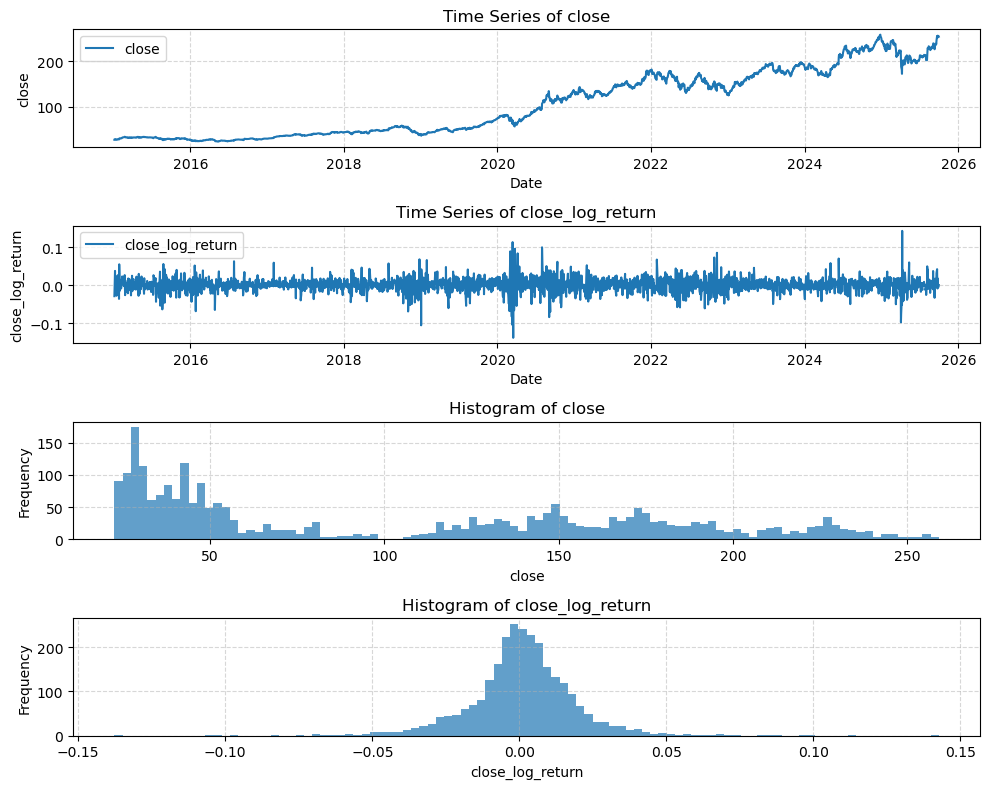

In [ ]:
fig, axes = plt.subplots(4, 1 , figsize=(10, 8), sharex=False)

pr.plot_time_series(df, "close", ax=axes[0])
pr.plot_time_series(df, "close_log_return", ax=axes[1])
pr.histogram_distribution(df, "close", bins=100, ax=axes[2])
pr.histogram_distribution(df,"close_log_return", bins = 100, ax=axes[3])

plt.tight_layout()
plt.show()


In [ ]:
df_model1 = df[["date", "close_log_return"]].copy()

In [ ]:
# Check stationary using adfuller test

from statsmodels.tsa.stattools import adfuller

adf = adfuller(df["close_log_return"])
print("p-value:", adf[1])

p-value: 1.3157758929649384e-29


Since p-value in adfuller test < 0.05 thus this series is stationary.

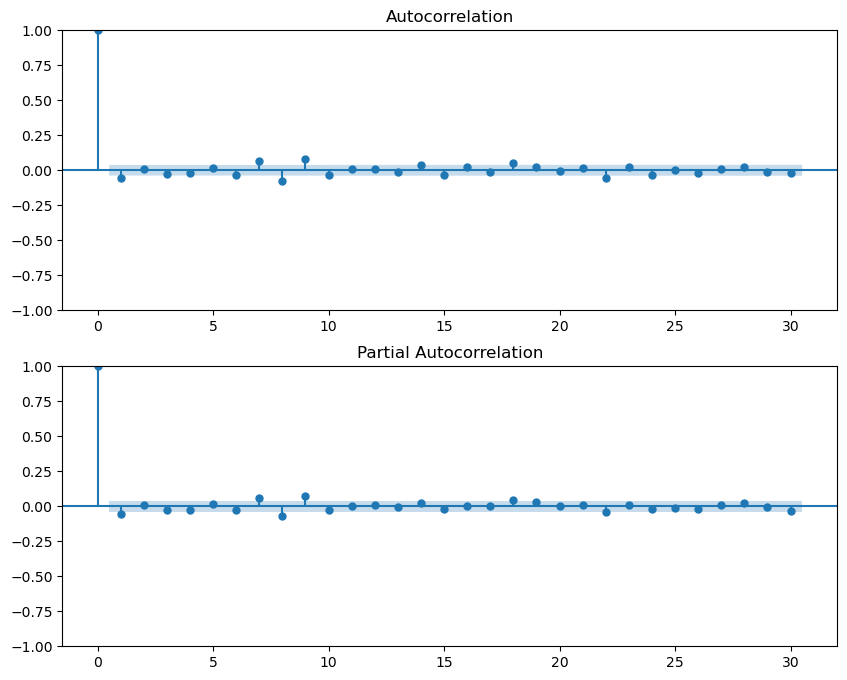

In [ ]:
# Plot ACF va PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df["close_log_return"], lags=30, ax=ax[0])
plot_pacf(df["close_log_return"], lags=30, ax=ax[1])

plt.show()

In [ ]:
# Split Data

train_set, _, test_set = dg.vanilla_split_data(df_model1, train_size=0.8, val_size=0, test_size=0.2, purge_size=5)

In [ ]:
# Detect outlier using MAD

outlier.visualize_outliers(train_set, "close_log_return", method=outlier.detect_outliers_mad, threshold=3, window_size = 63)


In [ ]:
# Hanlde outlier by using winsorization 99% and 1% in Train set
detected_train = outlier.detect_outliers_iqr(
    train_set,
    column="close_log_return",
    k=1.5,
    window_size=63,
    lower_quartile=0.25,
    upper_quartile=0.75
)



X_train = outlier.handle_outliers(
    train_set,
    column="close_log_return",
    method=outlier.detect_outliers_iqr,
    k=1.5,
    window_size=63,
    lower_quartile=0.25,
    upper_quartile=0.75
)

In [ ]:
X_train

,date,close_log_return
0,2015-01-05,-0.028576
1,2015-01-06,0.000094
2,2015-01-07,0.013925
3,2015-01-08,0.037703
4,2015-01-09,0.001072
...,...,...
2155,2023-07-28,0.013418
2156,2023-07-31,0.003161
2157,2023-08-01,-0.004285
2158,2023-08-02,-0.015611


In [ ]:
outlier.visualize_outliers(X_train, "close_log_return", method=outlier.detect_outliers_iqr, k=1.5, window_size = 63)

In [ ]:
lower_bound = detected_train["lower_bound"].min()   
upper_bound = detected_train["upper_bound"].max()

X_test = test_set[["close_log_return"]].clip(lower=lower_bound, upper=upper_bound)


In [ ]:
X_test

,close_log_return
2165,-0.001012
2166,0.009349
2167,-0.011264
2168,-0.004971
2169,-0.014662
...,...
2696,-0.008367
2697,0.017912
2698,-0.005504
2699,-0.004040


In [ ]:
# Find ARIMA order (p, d, q)
from pmdarima import auto_arima

stepwise_model = auto_arima(
    X_train['close_log_return'],
    seasonal=False,
    max_p=5, max_q=5,
    max_d=2,
    information_criterion='aic',
    trace=True
)

print(stepwise_model.order)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11621.518, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11617.880, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-11620.406, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-11620.579, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11617.133, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-11617.181, Time=0.52 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-11614.523, Time=0.69 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11614.423, Time=1.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11619.022, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11615.279, Time=0.47 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-11616.568, Time=0.52 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-11612.477, Time=0.58 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11623.137, Time=1.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11622.148, Time=0.53 sec
 ARIM

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
WINDOW_SIZE = 30
y_hat = []
for t in range(WINDOW_SIZE, len(train_set)):
    train_data = train_set["close_log_return"].iloc[t-WINDOW_SIZE:t]
    try:
        model = ARIMA(train_data, order=stepwise_model.order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        
    except:
        forecast = 0 # Fallback if model fails to converge
    y_hat.append(forecast)

In [ ]:
trade_results = pd.DataFrame({
    "y_hat":y_hat,
    "y":train_set["close_log_return"][30:]})
trade_results

,y_hat,y
30,0.005218,0.006938
31,0.006370,-0.002100
32,0.006787,0.008141
33,0.005825,0.026668
34,0.004541,-0.006260
...,...,...
2155,0.003145,0.013418
2156,0.000204,0.003161
2157,0.001333,-0.004285
2158,0.003034,-0.015611


In [ ]:
trade_results[trade_results["y_hat"]<0]

,y_hat,y
46,-0.001032,0.017918
53,-0.000751,0.010351
56,-0.000214,0.006946
57,-0.000678,-0.008000
58,-0.000028,0.024999
...,...,...
2029,-0.000434,0.014695
2035,-0.000939,0.024107
2066,-0.000667,0.011873
2108,-0.000745,0.000628


In [ ]:
trade_results["signal"] = np.sign(trade_results["y_hat"])
trade_results["signal"]

30      1.0
31      1.0
32      1.0
33      1.0
34      1.0
       ... 
2155    1.0
2156    1.0
2157    1.0
2158    1.0
2159    1.0
Name: signal, Length: 2130, dtype: float64

In [ ]:
trade_results['signal'].value_counts()

signal
 1.0    1296
-1.0     834
Name: count, dtype: int64

In [ ]:
trade_results["is_won"] = np.where(np.sign(trade_results["y_hat"]) == np.sign(trade_results["y"]), 1, 0)

In [ ]:
trade_results["trade_log_return"] = (trade_results["signal"].shift(1)*trade_results["y"])

In [ ]:
trade_results["equity_curve"] = trade_results['trade_log_return'].cumsum()

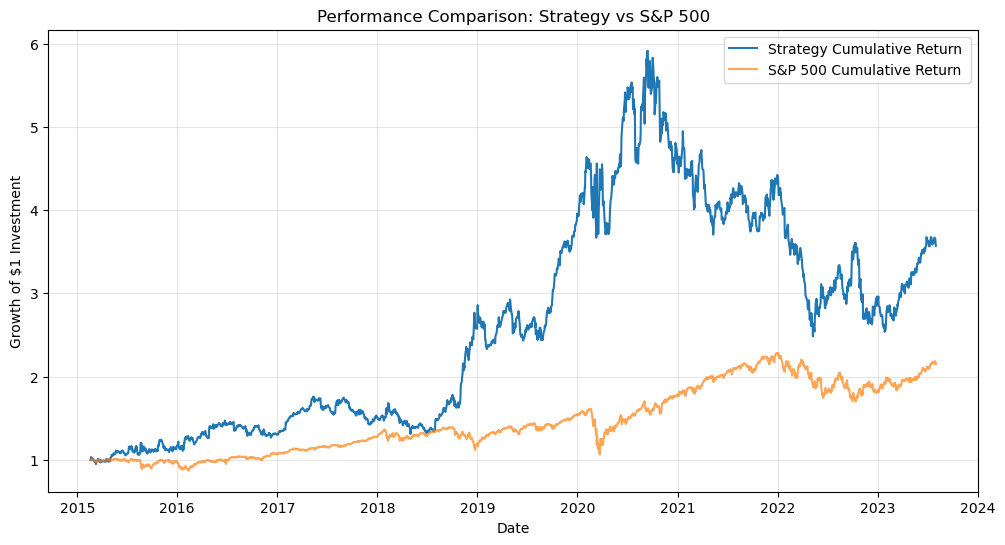

In [ ]:
# Compare with S&P500

df_compare = pd.DataFrame()

df_compare['Strategy_Ret'] = trade_results['trade_log_return'] 
df_compare['Benchmark_Ret'] = df_SP500['close_log_return']
df_compare['date'] =  df_SP500['date']


df_compare.dropna(inplace=True)

df_compare['Strategy_Equity'] = np.exp(df_compare['Strategy_Ret'].cumsum())
df_compare['Benchmark_Equity'] = np.exp(df_compare['Benchmark_Ret'].cumsum())

plt.figure(figsize=(12, 6))
plt.plot(df_compare['date'], df_compare['Strategy_Equity'], label=f'Strategy Cumulative Return')
plt.plot(df_compare['date'], df_compare['Benchmark_Equity'], label=f'S&P 500 Cumulative Return ', alpha=0.7)

plt.title('Performance Comparison: Strategy vs S&P 500')
plt.ylabel('Growth of $1 Investment')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import math

strategy_metrics = {
    "Win Rate": trade_results["is_won"].mean(),
    "Mean Log Return": trade_results["trade_log_return"].mean(),
    "Std Log Return": trade_results["trade_log_return"].std(),
    "Max Log Drawdown": (trade_results["equity_curve"] - trade_results["equity_curve"].cummax()).min(),
    "Sharpe Ratio": (trade_results["trade_log_return"].mean() / trade_results["trade_log_return"].std()) * math.sqrt(252)
}

# Metrics BENCHMARK (S&P 500)
sp500_log_ret = df_SP500["close_log_return"]
sp500_cum_ret = sp500_log_ret.cumsum()

benchmark_metrics = {
    # Win rate của thị trường là tỷ lệ số ngày tăng giá
    "Win Rate": (sp500_log_ret > 0).mean(),
    
    "Mean Log Return": sp500_log_ret.mean(),
    "Std Log Return": sp500_log_ret.std(),
    
    # Tính Drawdown cho Benchmark
    "Max Log Drawdown": (sp500_cum_ret - sp500_cum_ret.cummax()).min(),
    
    # Sharpe Ratio (Annualized)
    "Sharpe Ratio": (sp500_log_ret.mean() / sp500_log_ret.std()) * math.sqrt(252)
}

In [ ]:
#  Create DataFrame
comparison_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=["Strategy", "S&P 500"])

# Transpose 
comparison_df = comparison_df.T

print(comparison_df)


                  Strategy   S&P 500
Win Rate          0.501878  0.539230
Mean Log Return   0.000598  0.000436
Std Log Return    0.018529  0.011380
Max Log Drawdown -0.866973 -0.414379
Sharpe Ratio      0.512229  0.608676
